{% include toc title="In This Lesson" icon="file-text" %}

<div class='notice--success' markdown="1">

## <i class="fa fa-graduation-cap" aria-hidden="true"></i> Learning Objectives

After completing this tutorial, you will be able to:

* Use the `extract()` function to extract raster values using a vector extent or set of extents.
* Create a scatter plot with a one to one line in `R`.
* Understand the concept of uncertainty as it's associated with remote sensing data.

## <i class="fa fa-check-square-o fa-2" aria-hidden="true"></i> What you need

You will need a computer with internet access to complete this lesson and the data for week 5 of the course.

[<i class="fa fa-download" aria-hidden="true"></i> Download Week 5 Data (~500 MB)](https://ndownloader.figshare.com/files/7525363){:data-proofer-ignore='' .btn }


</div>

First let's import the needed libraries and make sure our working directory is set

In [177]:
# import all libraries
import os
import numpy as np
import rasterio as rio
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterstats as rs
import pandas as pd
#from rasterio import plot as riop
plt.ion()

# be sure to set your working directory
os.chdir("/Users/lewa8222/Documents/earth-analytics")

## Import Canopy Height Model

First, we will import a canopy height model created by the NEON project. In the
previous lessons / weeks we learned how to make a canopy height model by
subtracting the Digital elevation model (DEM) from the Digital surface model (DSM).

* first open and view histogram
then fix data...

## is there an easy way to view summary stats?
## any reason to not use context manager throughout? (code is commented)


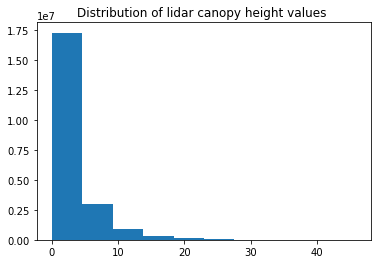

In [178]:
# So do i need to use a context manager each time - here we don't use it.
# carson suggests we probably should
#SJER_chm = rio.open('data/week5/california/SJER/2013/lidar/SJER_lidarCHM.tif')

with rio.open('data/week5/california/SJER/2013/lidar/SJER_lidarCHM.tif') as lidar_chm_src:
    # read the data into a numpy array
    # note that the (1) ensures you get a 2 dimensional object rather than 3
    SJER_chm_data = lidar_chm_src.read(1, masked=True) 

# read in data -- not sure if masked = True works
# can we create summary stats on the array?

#SJER_chm_data = SJER_chm.read(masked=True)

# plot histogram
# Need to add x and y labels to plot and title 
fig, ax = plt.subplots()
ax.hist(SJER_chm_data.compressed())
plt.title('Distribution of lidar canopy height values ')



In [179]:
print('Mean:', SJER_chm_data.mean())
print('Max:', SJER_chm_data.max())
print('Min:', SJER_chm_data.min())

Mean: 1.9355862432
Max: 45.88
Min: 0.0


## Data values
Looking at the distribution of data, it appears as if there is a skew around 0. IN this case, there are a lot of pixels with a value of 0 - where there are no trees. We may want to set these values to NA as the will impact our plot summary statistics.

## Clean CHM data

Notice that when we import the raster below, we use a context manager `with`. This creates a 
connection to our geotiff dataset. When the with segment of code ends, the connection to 
the dataset is then closed for us. 

The code below performs the following tasks:

1. we create a connection to the `SJER_lidarCHM.tif` geotiff file. 
2. We then read in the actual data as a numpy array. This allows us to manipulate the data. Notice that the code below uses `read(1)` - this tells python to only import the FIRST BAND of our raster. In this case we only have one band but we need to specify that we are only importing that one band. 

`SJER_chm_data = lidar_chm_src.read(1)`

3. Finally we set all pixels that have the value of 0 to `nan` (no data values)
`SJER_chm_data[SJER_chm_data==0] = np.nan`
4. Finally we grab the spatial attributes of our original raster and save them to a variable called `profile`.

`profile = lidar_chm_src.profile`

In [180]:
# load lidar canopy height model raster  using rasterio
# note that we are using a context manager - with to do this 
with rio.open('data/week5/california/SJER/2013/lidar/SJER_lidarCHM.tif') as lidar_chm_src:
    # read the data into a numpy array
    # note that the (1) ensures you get a 2 dimensional object rather than 3
    SJER_chm_data = lidar_chm_src.read(1) 
    # set CHM values of 0 to NAN
    SJER_chm_data[SJER_chm_data==0] = np.nan
    profile = lidar_chm_src.profile

# https://mapbox.github.io/rasterio/quickstart.html


## Spatial attributes stored in a dictionary

Before we go any further, let's have a look at the `profile` object. This object is a dictionary that contains all of the spatial attributes of our original geotiff. 

When we read the data into a numpy array, it becomes a generic object with no spatial attributes. A numpy array only contains the pixel values for each cell stored in an `array` or matrix format. 

In [181]:
type(profile)

dict

If we look at the profile object we will see all of the attributes. We are going to use that object to 
set all of the spatial attributes when we write out our modified numpy array to a new geotiff.


In [182]:
profile

{'affine': Affine(1.0, 0.0, 254571.0,
       0.0, -1.0, 4112362.0),
 'compress': 'lzw',
 'count': 1,
 'crs': CRS({'init': 'epsg:32611'}),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 5059,
 'interleave': 'band',
 'nodata': -9999.0,
 'tiled': False,
 'transform': (254571.0, 1.0, 0.0, 4112362.0, 0.0, -1.0),
 'width': 4296}





There are a lot of values in our CHM that == 0. Let's set those to `NA` and plot

again.




In [183]:
# load lidar canopy height model raster  using rasterio
# note that we are using a context manager - with to do this 
with rio.open('data/week5/california/SJER/2013/lidar/SJER_lidarCHM.tif') as lidar_chm_src:
    # read the data into a numpy array
    # note that the (1) ensures you get a 2 dimensional object rather than 3
    SJER_chm_data = lidar_chm_src.read(1) 
    # set CHM values of 0 to NAN
    # currently this seems to be assigning all values to nan
    # instead i set it tot he no data value which is -9999.0
    SJER_chm_data[SJER_chm_data == 0] = -9999
    profile = lidar_chm_src.profile


In [184]:
# what is .ravel -- a flattened array? i don't think we want that 
#SJER_chm_data_ravel = SJER_chm_data.ravel()
#SJER_chm_data_ravel = SJER_chm_data_ravel[SJER_chm_data_ravel > 0]

# create histogram 
#fig, ax = plt.subplots()
#ax.hist(SJER_chm_data_ravel)

print('MEAN:',SJER_chm_data.mean())
print('MIN:',SJER_chm_data.min())
print('MAX:',SJER_chm_data.max())
# create histogram 
#fig, ax = plt.subplots()
#ax.hist(SJER_chm_data)

MEAN: -7640.71
MIN: -9999.0
MAX: 45.88


In [185]:
# ok so this is a masked array -- need to better understand ravel
# then need to understand how you'd export this to a geotiff if need be. 
type(SJER_chm_data)

numpy.ndarray

Finally, export the cleaned data to a geotiff. Notice that we have a nodatavalue specified in our profile object.

In [186]:
# assign cleaned lidar path
lidar_path = 'sjer_chm_zero_removed.tif'
# write a new geotiff using the spatial attributes of the original data 
with rio.open(lidar_path, 'w', **profile) as dst:
     # astype ensures the output format is correct 
    dst.write(SJER_chm_data.astype(rio.float32), 1) 


/Users/lewa8222/anaconda/lib/python3.6/site-packages/rasterio/__init__.py:160: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


Finally let's have a look at a historgram of the cleaned, exported CHM data. Note that when we import the 
data, we set masked=True to make sure that python maskes out our NA or no data values. 

In [187]:
# open the masked CHM geotiff
with rio.open(lidar_path) as lidar_chm2_src:
    SJER_chm2_data = lidar_chm2_src.read(1, masked=True)
   
# view mean, min max
print('MEAN:',SJER_chm2_data.mean())
print('MIN:',SJER_chm2_data.min())
print('MAX:',SJER_chm2_data.max())


MEAN: 8.21350469357
MIN: 2.0
MAX: 45.88


##  View distribution of pixel values

Finally we can plot a historgram which represents the distribution of pixels values in our raster.
By using the `.compressed()` attribute, we force python to ignore no data values (-9999 values in this case). 

# can we add outlines to each bar?

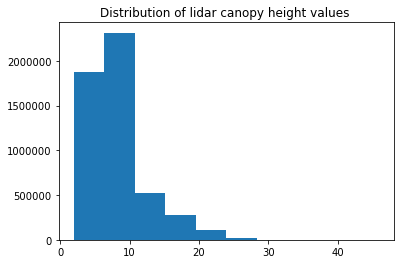

In [188]:
# create histogram 
fig, ax = plt.subplots()
# .compressed() forces numpy to not plot the NA values
ax.hist(SJER_chm2_data.compressed())
plt.title('Distribution of lidar canopy height values ')


## Part 2. Does our CHM data compare to field measured tree heights?

We now have a canopy height model for our study area in California. However, how
do the height values extracted from the CHM compare to our laboriously collected,
field measured canopy height data? To figure this out, we will use *in situ* collected
tree height data, measured within circular plots across our study area. We will compare
the maximum measured tree height value to the maximum LiDAR derived height value
for each circular plot using regression.

For this activity, we will use the a `csv` (comma separate value) file,
located in `SJER/2013/insitu/veg_structure/D17_2013_SJER_vegStr.csv`.

First we import the shapefile that contains the plot centroid locations using geopandas.

In [189]:
SJER_plots = gpd.read_file('data/week5/california/SJER/vector_data/SJER_plot_centroids.shp')
type(SJER_plots)

geopandas.geodataframe.GeoDataFrame

In [190]:
# view spatial extent of shapefile 
SJER_plots.total_bounds

(254738.61799999999, 4107527.074, 258497.10200000001, 4112167.7779999999)

## Data structure
We can use `SJER_plots.geom_type.head()` to determine the vector type of the shapefile that we imported. Below, we see that the data are stored as points. These points represent the centroid (or hte center) of the plot where trees were measured. We want to extract tree height values derived from the lidar data for the entire plot. To do this, we will need to create a BUFFER around the points.

In [191]:
SJER_plots.geom_type.head()

0    Point
1    Point
2    Point
3    Point
4    Point
dtype: object

In this case our plot size is 40m. If we create a circular buffer wiht a 20m diameter it will closely approximate where trees were measured on the ground. 

We can use the .buffer() function to create the buffer. Here the buffer size is specified in the () of the function. We will send the new object to a new shapefile using .to_file() as follows:

`SJER_plots.buffer(20).to_file('path-to-shapefile-here.shp')`


In [192]:
# sneaky assign the buffer geometry to the points layer to maintain attributes
SJER_plots["geometry"] = SJER_plots.geometry.buffer(20)
SJER_plots["geometry"]

# export the layer as a shapefile to use in zonal stats
plot_buffer_path = 'plot_buffer.shp'
SJER_plots.to_file(plot_buffer_path)

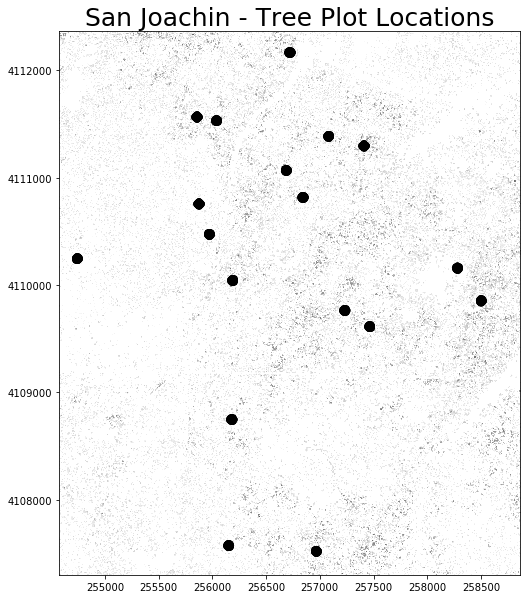

In [193]:
# Why do you need to specify the extent here? 
# why is the point all black - ie the color isn't takig and it seems to be dominated by the fill?
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(SJER_chm.read(masked=True)[0], 
          extent=[bounds.left, bounds.right, bounds.bottom, bounds.top], 
          cmap='Greys')
SJER_plots.plot(ax=ax, # overlay points on the ax plot
                marker='o', 
                markersize=5, # set point symbol size
                color='purple') # set point color
ax.set_title("San Joachin - Tree Plot Locations", 
             fontsize=25)

## Extract pixel values for each plot 

Once we have the boundary for each plot location (a 20m diameter circle) we can extract all of the pixels that fall within each circle using the function `zonal_stats` in the `rasterstats` library. 



### Extract CMH data within 20 m radius of each plot centroid.

Next, we will create a boundary region (called a buffer) representing the spatial
extent of each plot (where trees were measured). We will then extract all CHM pixels
that fall within the plot boundary to use to estimate tree height for that plot.

There are a few ways to go about this task. If our plots are circular, then we can
use the `extract()` function.

<figure>
    <img src="{{ site.url }}/images/course-materials/earth-analytics/week-5/buffer-circular.png" alt="buffer circular">
    <figcaption>The extract function in R allows you to specify a circular buffer
    radius around an x,y point location. Values for all pixels in the specified
    raster that fall within the circular buffer are extracted. In this case, we
    will tell R to extract the maximum value of all pixels using the fun=max
    command. Source: Colin Williams, NEON
    </figcaption>
</figure>

### Extract Plot Data Using Circle: 20m Radius Plots

In [194]:
# import new geotiff with 0's removed
# Extract zonal stats
sjer_tree_heights = rs.zonal_stats(plot_buffer_path, 
            lidar_path, 
            geojson_out=True,
            copy_properties=True,
            stats="count min mean max median")
# view first item in dictionary
sjer_tree_heights[1]


/Users/lewa8222/anaconda/lib/python3.6/site-packages/rasterstats/main.py:142: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  with Raster(raster, affine, nodata, band) as rast:
/Users/lewa8222/anaconda/lib/python3.6/site-packages/rasterstats/io.py:242: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  self.affine = guard_transform(self.src.transform)


{'geometry': {'coordinates': [[(257426.967, 4111298.971),
    (257426.87069453346, 4111297.010657193),
    (257426.58270560807, 4111295.0691935597),
    (257426.10580671465, 4111293.165306455),
    (257425.44459065024, 4111291.3173313527),
    (257424.60542528698, 4111289.5430652634),
    (257423.59639224605, 4111287.8595953393),
    (257422.42720906725, 4111286.2831343166),
    (257421.10913562373, 4111284.828864376),
    (257419.6548656833, 4111283.5107909325),
    (257418.0784046604, 4111282.3416077537),
    (257416.3949347365, 4111281.332574713),
    (257414.62066864732, 4111280.4934093496),
    (257412.7726935451, 4111279.832193285),
    (257410.86880644032, 4111279.355294392),
    (257408.9273428066, 4111279.0673054666),
    (257406.967, 4111278.971),
    (257405.00665719341, 4111279.0673054666),
    (257403.06519355968, 4111279.355294392),
    (257401.16130645492, 4111279.832193285),
    (257399.3133313527, 4111280.4934093496),
    (257397.5390652635, 4111281.332574713),
    (25

In [195]:
# turn extracted data into a pandas geo data frame 
SJER_lidar_height_df = gpd.GeoDataFrame.from_features(sjer_tree_heights)
SJER_lidar_height_df.head()

,Plot_ID,Point,count,easting,geometry,max,mean,median,min,northing,plot_type
0,SJER1068,center,161,255852.376,"POLYGON ((255872.376 4111567.818, 255872.27969...",19.049999,11.544347,12.62,2.04,4111567.818,trees
1,SJER112,center,443,257406.967,"POLYGON ((257426.967 4111298.971, 257426.87069...",24.019999,10.369277,7.87,2.10,4111298.971,trees
2,SJER116,center,643,256838.760,"POLYGON ((256858.76 4110819.876, 256858.663694...",16.070000,7.518398,6.80,2.82,4110819.876,grass
3,SJER117,center,245,256176.947,"POLYGON ((256196.947 4108752.026, 256196.85069...",11.059999,7.675346,7.93,3.24,4108752.026,trees
4,SJER120,center,17,255968.372,"POLYGON ((255988.372 4110476.079, 255988.27569...",5.740000,4.591177,4.45,3.38,4110476.079,grass


#### Explore The Data Distribution

If you want to explore the data distribution of pixel height values in each plot,
you could remove the `fun` call to max and generate a list.
`cent_ovrList <- extract(chm,centroid_sp,buffer = 20)`. It's good to look at the
distribution of values we've extracted for each plot. Then you could generate a
histogram for each plot `hist(cent_ovrList[[2]])`. If we wanted, we could loop
through several plots and create histograms using a `for loop`.


In [196]:

# this should show how to create a histogram of tree heights for each plot 
# we can skip this if it's not possible with  zonal stats...



## Extract descriptive stats from *In situ* Data
In our final step, we will extract summary height values from our field data.
We will use the `dplyr` library to do this efficiently.

First let's see how many plots are in our tree height data. Note that our tree
height data is stored in csv format.

In [197]:
# import in situ data
path_insitu = 'data/week5/california/SJER/2013/insitu/veg_structure/D17_2013_SJER_vegStr.csv'
SJER_insitu = pd.read_csv(path_insitu)
# what is the structure of the data
type(SJER_insitu)
# view the first 5 rows of data
SJER_insitu.head()

,siteid,sitename,plotid,easting,northing,taxonid,scientificname,indvidual_id,pointid,individualdistance,...,canopyform,livingcanopy,inplotcanopy,materialsampleid,dbhqf,stemmapqf,plant_group,common_name,aop_plot,unique_id
0,SJER,San Joaquin,SJER128,257085.7,4111381.5,PISA2,Pinus sabiniana,1485,center,9.7,...,NaN,100,100,NaN,0,0,NaN,NaN,NaN,NaN
1,SJER,San Joaquin,SJER2796,256047.7,4111548.5,ARVI4,Arctostaphylos viscida,1622,NE,5.8,...,Hemisphere,70,100,f095,0,0,NaN,NaN,NaN,NaN
2,SJER,San Joaquin,SJER272,256722.9,4112170.2,ARVI4,Arctostaphylos viscida,1427,center,6.0,...,Hemisphere,35,100,NaN,0,0,NaN,NaN,NaN,NaN
3,SJER,San Joaquin,SJER112,257421.4,4111308.2,ARVI4,Arctostaphylos viscida,1511,center,17.2,...,Sphere,70,100,f035,0,0,NaN,NaN,NaN,NaN
4,SJER,San Joaquin,SJER272,256720.5,4112177.2,ARVI4,Arctostaphylos viscida,1431,center,9.9,...,Sphere,80,100,f087,0,0,NaN,NaN,NaN,NaN


We want to calculate a summary value of max tree height (the tallest tree measured) in each plot. 
We have a unique id for each plot - **plotid** that we can use to group the data. The tree height values themselves are located in the **stemheight** column.

We can calculate this by using the .groupy() method in pandas. Note that the statement below 

## what is reset_index??

## Extract Max Tree Height

Next, we can use dplyr to extract a summary tree height value for each plot. In
this case, we will calculate the mean MEASURED tree height value for each
plot. This value represents the average tree in each plot. We will also calculate
the max height representing the max height for each plot.

FInally, we will compare the mean measured tree height per plot to the mean
tree height extracted from the lidar CHM.

In [198]:
## extract max tree height for each plot
insitu_stem_height = SJER_insitu.groupby('plotid').max()['stemheight'].reset_index()
# view the top 
insitu_stem_height

,plotid,stemheight
0,SJER1068,19.3
1,SJER112,23.9
2,SJER116,16.0
3,SJER117,11.0
4,SJER120,8.8
5,SJER128,18.2
6,SJER192,13.7
7,SJER272,12.4
8,SJER2796,9.4
9,SJER3239,17.9


### Merge InSitu Data With Spatial data.frame

Once we have our summarized insitu data, we can `merge` it into the centroids
`data.frame`. Merge requires two data.frames and the names of the columns
containing the unique ID that we will merge the data on. In this case, we will
merge the data on the plot_id column. Notice that it's spelled slightly differently
in both data.frames so we'll need to tell R what it's called in each data.frame.


In [199]:
# join data
# note the code below doesn't work because the attributes didn't transfer when i created the buffer object
SJER_final_height = pd.merge(insitu_stem_height, 
                       SJER_lidar_height_df, 
                       left_on='plotid', 
                       right_on='Plot_ID')
SJER_final_height

,plotid,stemheight,Plot_ID,Point,count,easting,geometry,max,mean,median,min,northing,plot_type
0,SJER1068,19.3,SJER1068,center,161,255852.376,"POLYGON ((255872.376 4111567.818, 255872.27969...",19.049999,11.544347,12.620000,2.04,4111567.818,trees
1,SJER112,23.9,SJER112,center,443,257406.967,"POLYGON ((257426.967 4111298.971, 257426.87069...",24.019999,10.369277,7.870000,2.10,4111298.971,trees
2,SJER116,16.0,SJER116,center,643,256838.760,"POLYGON ((256858.76 4110819.876, 256858.663694...",16.070000,7.518398,6.800000,2.82,4110819.876,grass
3,SJER117,11.0,SJER117,center,245,256176.947,"POLYGON ((256196.947 4108752.026, 256196.85069...",11.059999,7.675346,7.930000,3.24,4108752.026,trees
4,SJER120,8.8,SJER120,center,17,255968.372,"POLYGON ((255988.372 4110476.079, 255988.27569...",5.740000,4.591177,4.450000,3.38,4110476.079,grass
5,SJER128,18.2,SJER128,center,381,257078.867,"POLYGON ((257098.867 4111388.57, 257098.770694...",19.139999,8.987087,8.020000,2.16,4111388.570,trees
6,SJER192,13.7,SJER192,center,929,256683.434,"POLYGON ((256703.434 4111071.087, 256703.33769...",16.549999,7.229096,6.630000,2.20,4111071.087,grass
7,SJER272,12.4,SJER272,center,711,256717.467,"POLYGON ((256737.467 4112167.778, 256737.37069...",11.840000,7.107061,6.980000,2.37,4112167.778,trees
8,SJER2796,9.4,SJER2796,center,270,256034.390,"POLYGON ((256054.39 4111533.879, 256054.293694...",20.279999,6.409630,6.230000,2.03,4111533.879,soil
9,SJER3239,17.9,SJER3239,center,195,258497.102,"POLYGON ((258517.102 4109856.983, 258517.00569...",12.910000,6.009128,5.950000,2.02,4109856.983,soil




## Plot by height




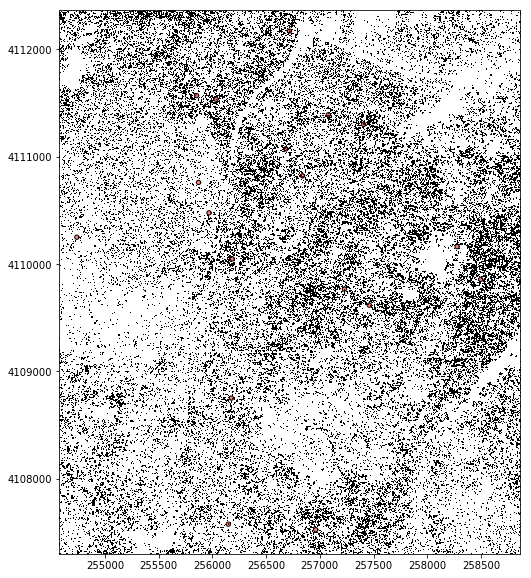

In [200]:
# this is a spatial plot where the points are sized according to tree height
# points overlaid on top of the chm ...

# this is just a plot of field plot locations overlayed on top of the chm
img = SJER_chm.read().squeeze()
img[img == 0] = np.nan

fig, ax = plt.subplots(figsize=(10, 10))
# riop.show(SJER_chm, cmap='Greys', ax=ax)
ax.imshow(img, cmap='Greys', extent=[SJER_chm.bounds[ii] for ii in [0, 2, 1, 3]])
# why are the markers so tiny tiny?!
SJER_plots.plot(ax=ax, markersize=500, color='r')





### Plot Data (CHM vs Measured)

Let's create a plot that illustrates the relationship between in situ measured

max canopy height values and lidar derived max canopy height values.






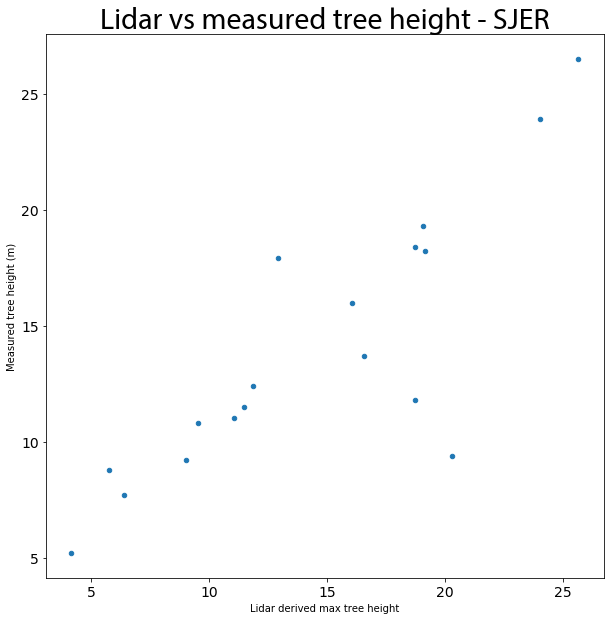

In [201]:
# this plot should be a scatter plot with labels and such
# how to add x and y labels
# http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.plot.html
# Prettier plots: https://datasciencelab.wordpress.com/2013/12/21/beautiful-plots-with-pandas-and-matplotlib/
fig, ax = plt.subplots(figsize=(10, 10))

csfont = {'fontname':'Myriad Pro'}
SJER_final_height.plot('max', 'stemheight', 
                       kind='scatter',
                       title="Lidar vs measured tree height - SJER", 
                       fontsize=14, ax=ax)

ax.set(xlabel="Lidar derived max tree height", 
       ylabel="Measured tree height (m)")
# Customize title, set position, allow space on top of plot for title
# this doesn't work - i'm not sure why
ax.set_title(ax.get_title(), 
             fontsize=30, 
             **csfont)
# ax.set_xlabel(xlabel, fontsize=20, ha='left')





Next, let's fix the plot adding a 1:1 line and making the x and y axis the same .

## need to add a 1:1 line to the plot below


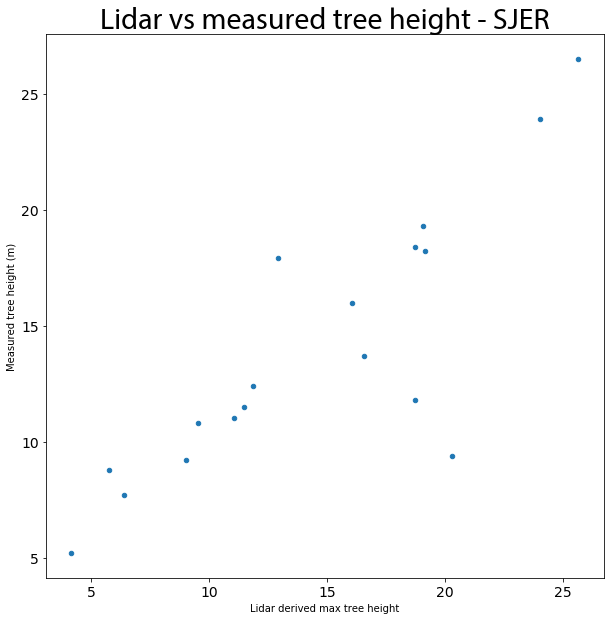

In [202]:
# this plot should be a scatter plot with labels and such
# how to add x and y labels
# http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.plot.html
# Prettier plots: https://datasciencelab.wordpress.com/2013/12/21/beautiful-plots-with-pandas-and-matplotlib/
fig, ax = plt.subplots(figsize=(10, 10))

csfont = {'fontname':'Myriad Pro'}
SJER_final_height.plot('max', 'stemheight', 
                       kind='scatter',
                       title="Lidar vs measured tree height - SJER", 
                       fontsize=14, ax=ax)

ax.set(xlabel="Lidar derived max tree height", 
       ylabel="Measured tree height (m)")
# Customize title, set position, allow space on top of plot for title
# this doesn't work - i'm not sure why
ax.set_title(ax.get_title(), 
             fontsize=30, 
             **csfont)
# ax.set_xlabel(xlabel, fontsize=20, ha='left')


We can also add a regression fit to our plot. Explore the GGPLOT options and
customize your plot.

# need to add a regression fit to the plot below




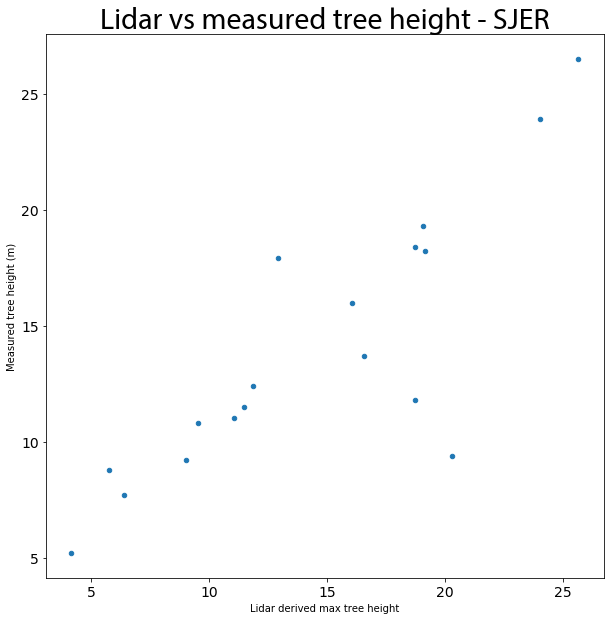

In [203]:
# this plot should be a scatter plot with labels and such
# how to add x and y labels
# http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.plot.html
# Prettier plots: https://datasciencelab.wordpress.com/2013/12/21/beautiful-plots-with-pandas-and-matplotlib/
fig, ax = plt.subplots(figsize=(10, 10))

csfont = {'fontname':'Myriad Pro'}
SJER_final_height.plot('max', 'stemheight', 
                       kind='scatter',
                       title="Lidar vs measured tree height - SJER", 
                       fontsize=14, ax=ax)

ax.set(xlabel="Lidar derived max tree height", 
       ylabel="Measured tree height (m)")
# Customize title, set position, allow space on top of plot for title
# this doesn't work - i'm not sure why
ax.set_title(ax.get_title(), 
             fontsize=30, 
             **csfont)
# ax.set_xlabel(xlabel, fontsize=20, ha='left')



## View Difference: lidar vs measured

# this doesn't look right... 


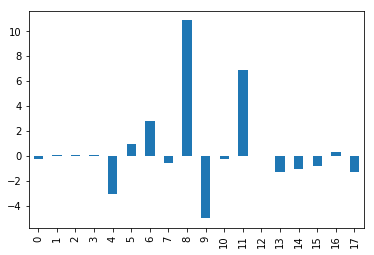

In [204]:

# Calculate difference
# also need to add the plot id to each xaxis label
SJER_final_height["lidar_measured"] = SJER_final_height["max"] - SJER_final_height["stemheight"]
SJER_final_height["lidar_measured"].plot(kind="bar")